# Tensor decomposition and prediction using interpolation of factors

Objective of this document is to make predictions at any parameter points by interpolation of factors.

Parametric space - dimensionality of $n_p$ + 2 (2D space and $n_p$ number of parameters):
- $n_p=1$ with frequency parameter - $\mathbb{R}^{m \times n} \times \left[\omega_\mathrm{min}, \omega_\mathrm{max}\right]$
- $n_p=1$ with other parameters $E,\nu,\rho,t$

In [94]:
import numpy as np
import tensorly as tl
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
from matplotlib import animation

import sys
sys.path.append('..') # source
sys.path.append('../codes/PlateKirchhoff') # source

import time
from copy import deepcopy

from codes.PlateKirchhoff.fe_system import fe_data

from codes.PlateKirchhoff.plate_systems import plate_system_5param_XY
from sklearn.model_selection import train_test_split

## FE System

In [95]:
solverTic = time.time()
# parameters
freq = np.linspace(10,400,2)

#coord = np.array([[0.,  0. ], [1.,  0. ], [1.,  0.7], [0.,  0.7]])
c_s = np.array([1., 0.7, 0.003])

# Structured nodal coordinates 
nElem_x = 20                                    # Number of elements in x direction
nElem_y = 20                                    # Number of elements in y direction

x = np.linspace(0,c_s[0],nElem_x+1)
y = np.linspace(0,c_s[1],nElem_y+1)

coord = np.zeros(((nElem_y+1)*(nElem_x+1),2)) # Two coords per node (x,y)
a_x = c_s[0] / nElem_x
a_y = c_s[1] / nElem_y
for m in range(nElem_x+1):
    for n in range(nElem_y+1):
        coord[m*(nElem_y+1)+n] = np.array([(m)*a_x, (n)*a_y])


# Generate element connectivity
connect = np.zeros((nElem_y*nElem_x,4), dtype=np.int32) # Four nodes per element (linear quadrilateral)
for m in range(nElem_x):
    for n in range(nElem_y):
        elem_connect = np.zeros(4, dtype=np.int32)
        elem_connect[0] = (m)*(nElem_y+1) + (n)
        elem_connect[1] = elem_connect[0] + (nElem_y+1)
        elem_connect[2] = elem_connect[1] + 1
        elem_connect[3] = elem_connect[0] + 1
        connect[m*nElem_y+n] = elem_connect

# Material properties
mat = np.array([7.0e+10, 3.4e-01, 2.7e+03])
material = np.zeros((nElem_x*nElem_y, 3))
material[:,:] = mat    # Emod, Poissons ratio, Density (Same material for all elements / homogeneous domain)

n_unkwn_elem_disp = connect.shape[0]*4
solverToc = time.time()
solverTime = solverToc - solverTic
print('>> Time for mesh gen: ' + str(round(solverTime,3)) + ' seconds.')

# arrange
my_fe_data = fe_data()
my_fe_data.coord = coord
my_fe_data.material = material
my_fe_data.pDim = c_s
my_fe_data.connect = connect
my_fe_data.bc = np.array([])
my_fe_data.grid_shape = (nElem_x+1, nElem_y+1)

def output_func(param):
    ranges = np.zeros((2,5))
    ranges[:,0] = np.array([np.min(freq), np.max(freq)]) # frequency
    ranges[:,1] = 7e10*np.array([0.90, 1.10]) # youngs modulus
    ranges[:,2] = 0.34*np.array([0.90, 1.10]) # poissons ratio
    ranges[:,3] = 2.7e3*np.array([0.90, 1.10]) # density
    ranges[:,4] = 0.003*np.array([0.90, 1.10]) # thickness
    
    scaler = MinMaxScaler()
    scaler.fit(ranges)
    
    physical_params = scaler.inverse_transform(np.atleast_2d(param)).flatten()
    print(f'Params: {physical_params}')    
    disp = plate_system_5param_XY(my_fe_data,physical_params).flatten()
    return disp
    

>> Time for mesh gen: 0.004 seconds.


## Sampling

In [96]:
generate = False
param_id = 4 # 0: frequency, 1: Young's modulus, 2: Poisson's ratio, 3: density, 4: thickness
if generate:
    X = np.linspace(0,1,100)
    X_train, X_test = train_test_split(X, test_size=0.2)

    # training data
    Y_train = tl.zeros((my_fe_data.grid_shape[0],my_fe_data.grid_shape[1], len(X_train)))
    for id,every_x in enumerate(X_train):
        param_pt = np.zeros(5)
        param_pt[param_id] = every_x
        Y_train[:,:,id] = output_func(param_pt).reshape(my_fe_data.grid_shape[0],my_fe_data.grid_shape[1])
        
    # test data
    Y_test = tl.zeros((my_fe_data.grid_shape[0],my_fe_data.grid_shape[1], len(X_test)))
    for id,every_x in enumerate(X_test):
        param_pt = np.zeros(5)
        param_pt[param_id] = every_x
        Y_test[:,:,id] = output_func(param_pt).reshape(my_fe_data.grid_shape[0],my_fe_data.grid_shape[1])
        
    np.savez(f'../data/tensor_traintest{param_id}.npz',X_train=X_train, X_test=X_test, Y_train=Y_train, Y_test=Y_test)

## Load generated data

In [97]:
tensor_data = np.load(f'../data/tensor_traintest{param_id}.npz')
X_train = tensor_data['X_train']
X_test = tensor_data['X_test']
Y_train = tensor_data['Y_train']
Y_test = tensor_data['Y_test']

# arrange for visualization
idx_sort = np.argsort(X_train)
X_train = X_train[idx_sort]
Y_train = Y_train[:,:,idx_sort]

## Tensor decomposition

In [98]:
from tensorly.decomposition import tucker

#r = [10,10,50]
r = [5,5,5]
factors_tl = tucker(Y_train, rank=r)
yFEM_Tensor_reconstructed = tl.tucker_to_tensor(factors_tl)
print(f'Reconstruction error: {tl.norm(Y_train-yFEM_Tensor_reconstructed)}')

Reconstruction error: 6.83199220270689e-05


## Factor views

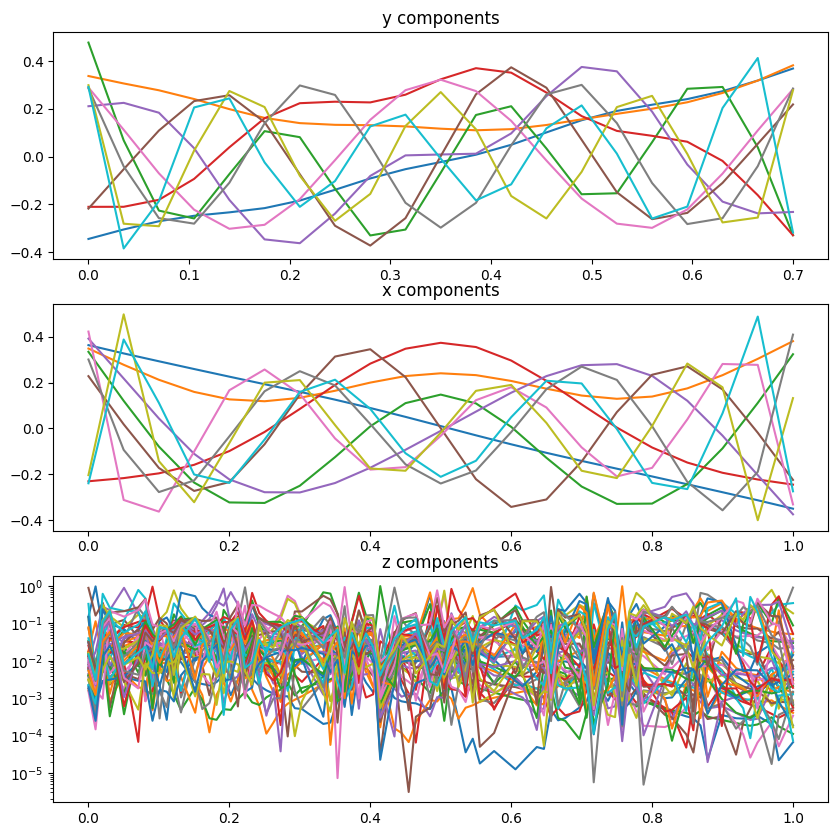

In [99]:
plt.figure(figsize=(10,10))
plt.subplot(311)
plt.plot(y,factors_tl[1][0][:,:r[0]])
plt.title('y components')
plt.subplot(312)
plt.plot(x,factors_tl[1][1][:,:r[1]])
plt.title('x components')
plt.subplot(313)
plt.semilogy(X_train,np.abs(factors_tl[1][2][:,:r[2]]))
plt.title('z components')
plt.show()

## Prediction at test points

In [100]:
from scipy.interpolate import RBFInterpolator

interp_factor = deepcopy(factors_tl)
X_predict = X_test

newfactors = RBFInterpolator(X_train.reshape(-1,1), factors_tl.factors[2])(X_predict.reshape(-1,1))
interp_factor.factors[2] = newfactors
yFEM_Tensor_predicted = tl.tucker_to_tensor(interp_factor)

Error checks:

In [101]:
diff_tensor = Y_test - yFEM_Tensor_predicted
print(f'Prediction error: {tl.norm(diff_tensor)}')

idmax = np.argmax(np.max(diff_tensor,axis=(0,1)))

Prediction error: 0.0726086787484083


Visualise:

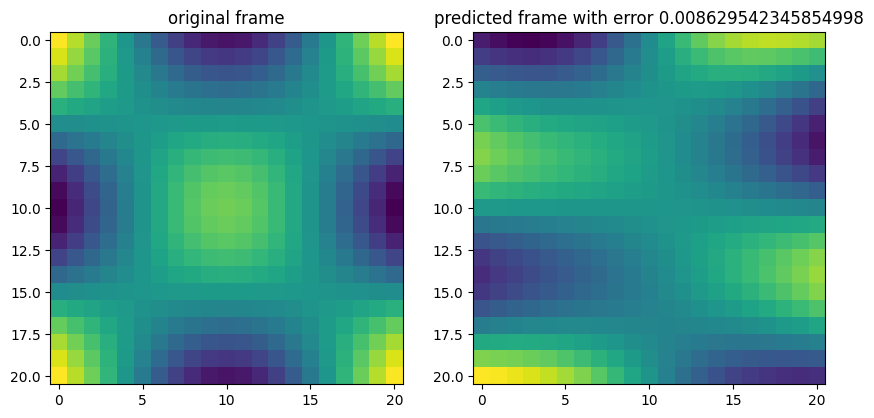

In [102]:
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(Y_test[:,:,idmax])
plt.title('original frame')
plt.subplot(122)
plt.imshow(yFEM_Tensor_predicted[:,:,idmax])
plt.title(f'predicted frame with error {np.max(diff_tensor[:,:,idmax])}')
plt.show()

## Prediction - combined test and train

In [103]:
from scipy.interpolate import RBFInterpolator

interp_factor = deepcopy(factors_tl)
X_combined =np.concatenate((X_test, X_train),axis=0)
idx_sorted = np.argsort(X_combined)
X_predict = X_combined[idx_sorted]
Y_combined = np.concatenate((Y_test, Y_train), axis=2)
Y_combined = Y_combined[:,:,idx_sorted]

newfactors = RBFInterpolator(X_train.reshape(-1,1), factors_tl.factors[2])(X_predict.reshape(-1,1))
interp_factor.factors[2] = newfactors
yFEM_Tensor_predicted = tl.tucker_to_tensor(interp_factor)

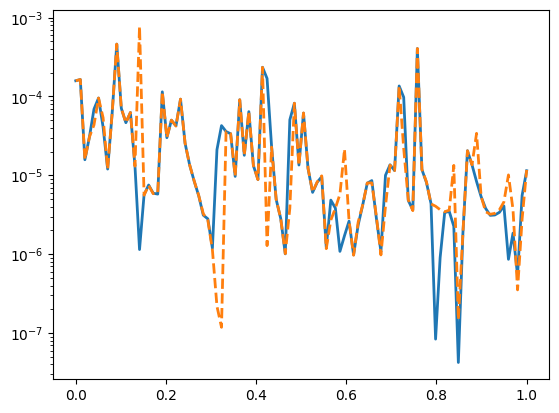

In [104]:
idx1 = 5 # node id in x
idx2 = 12 # node id in y

plt.figure()
plt.semilogy(X_predict, np.abs(yFEM_Tensor_predicted[idx1,idx2,:]),lw=2)
plt.semilogy(X_predict, np.abs(Y_combined[idx1,idx2,:]),lw=2,ls='--')
plt.show()